In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, confusion_matrix

In [4]:
from catboost import CatBoostClassifier

In [5]:
df = pd.read_csv('marketing_campaign.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             10037 non-null  object
 1   date_served         10021 non-null  object
 2   marketing_channel   10022 non-null  object
 3   variant             10037 non-null  object
 4   language_displayed  10037 non-null  object
 5   converted           10022 non-null  object
dtypes: object(6)
memory usage: 470.6+ KB


Проверить гипотезу о том, в каком варианте теста (control/personalization) больше конверсия (converted) и значимо ли это отличие статистически.

In [7]:
df = df.loc[df['converted'].notna()]

df['converted'].value_counts()

False    8946
True     1076
Name: converted, dtype: int64

In [8]:
df['converted'] = df['converted'].map(lambda x: int(x))

In [9]:
df['variant'].value_counts()

control            5076
personalization    4946
Name: variant, dtype: int64

In [10]:
y_A = df.loc[df['variant']=='control', 'converted']
y_B = df.loc[df['variant']=='personalization', 'converted']

In [11]:
k1, n1 = y_A.sum(), len(y_A)
k2, n2 = y_B.sum(), len(y_B)
k1, k2, n1, n2

(371, 705, 5076, 4946)

In [12]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                 np.array([n1, n2]))

print(f'Results are z_score={z_score:.3f} pvalue={z_pvalue:.3f}')

Results are z_score=-11.228 pvalue=0.000


In [13]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                        np.array([n1, n2]))

print(f'Results are chisq={chisq:.3f} pvalue={pvalue:.3f}')

Results are chisq=126.078 pvalue=0.000


По оббоим тестам конверсия достоверно отличается в контрольной группе и группе со специализированным подходом

Сначала не верно поняла задание и пробовала строить модель, предсказывающую вероятность покупки по имеющимся данным:

In [14]:
df = pd.read_csv('marketing_campaign.csv')

df1 = pd.read_csv('subscribers.csv')

df2 = pd.read_csv('users.csv')

In [15]:
# df1.info()

In [16]:
# df2.info()

In [17]:
data = pd.merge(df, df1, on='user_id', how='left')

In [18]:
full_data = pd.merge(data, df2, on='user_id', how='left')

In [19]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              10037 non-null  object
 1   date_served          10021 non-null  object
 2   marketing_channel    10022 non-null  object
 3   variant              10037 non-null  object
 4   language_displayed   10037 non-null  object
 5   converted            10022 non-null  object
 6   subscribing_channel  1856 non-null   object
 7   date_subscribed      1856 non-null   object
 8   date_canceled        577 non-null    object
 9   is_retained          1856 non-null   object
 10  age_group            10037 non-null  object
 11  language_preferred   10037 non-null  object
dtypes: object(12)
memory usage: 1019.4+ KB


Не буду рассматривать признаки, заполненные на 1/5 и меньше

In [20]:
data = full_data[['user_id', 'date_served', 'marketing_channel', 'variant', 'language_displayed',
            'language_preferred', 'age_group', 'converted']]

In [21]:
(data['language_displayed'] == data['language_preferred']).sum()

9515

Два поля совпадают более, чем в 95% случаев - одно удаляю.

In [22]:
data.drop('language_preferred', axis=1, inplace=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10037 entries, 0 to 10036
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             10037 non-null  object
 1   date_served         10021 non-null  object
 2   marketing_channel   10022 non-null  object
 3   variant             10037 non-null  object
 4   language_displayed  10037 non-null  object
 5   age_group           10037 non-null  object
 6   converted           10022 non-null  object
dtypes: object(7)
memory usage: 627.3+ KB


Нас интересуют только размеченные данные, т.е. только те, для которых поле converted - non-null

In [24]:
data = data.loc[data['converted'].notna()]

data['converted'].value_counts()

False    8946
True     1076
Name: converted, dtype: int64

In [25]:
data['converted'] = data['converted'].map(lambda x: int(x))

In [26]:
df = data.copy()

In [27]:
data['date_served'].fillna(data['date_served'].mode()[0], inplace=True)

In [28]:
from datetime import datetime

In [29]:
data['date_served'] = data['date_served'].map(lambda x: datetime.strptime(x, '%m/%d/%y').date())

In [30]:
data['date_served'].value_counts()

2018-01-15    790
2018-01-02    417
2018-01-16    391
2018-01-03    388
2018-01-01    375
2018-01-17    374
2018-01-31    347
2018-01-10    342
2018-01-04    336
2018-01-27    331
2018-01-05    331
2018-01-28    330
2018-01-30    330
2018-01-29    328
2018-01-20    321
2018-01-18    320
2018-01-08    319
2018-01-09    315
2018-01-06    315
2018-01-11    314
2018-01-14    309
2018-01-13    308
2018-01-19    308
2018-01-12    306
2018-01-07    281
2018-01-21    234
2018-01-26    225
2018-01-24    193
2018-01-25    186
2018-01-22    182
2018-01-23    176
Name: date_served, dtype: int64

Отличается только день - оставляю его

In [31]:
data['date_served'] = data['date_served'].map(lambda x: x.day)

In [32]:
data['marketing_channel'].value_counts()

House Ads    4733
Instagram    1871
Facebook     1860
Push          993
Email         565
Name: marketing_channel, dtype: int64

In [33]:
data['variant'].value_counts()

control            5076
personalization    4946
Name: variant, dtype: int64

In [34]:
data['variant'] = data['variant'].map({'control': 0, 'personalization': 1})

In [35]:
data['language_displayed'].value_counts()

English    9778
Spanish     136
German       81
Arabic       27
Name: language_displayed, dtype: int64

In [36]:
# data['language_n'] = data['language_displayed'].map(dict(data['language_displayed'].value_counts()))
data['language_n'] = data['language_displayed'].map({'English': 4, 'Spanish': 3, 'German': 2, 'Arabic': 1})

In [37]:
data['age_group'].value_counts()

19-24 years    1679
24-30 years    1566
0-18 years     1537
30-36 years    1353
45-55 years    1351
36-45 years    1351
55+ years      1185
Name: age_group, dtype: int64

In [38]:
data['age_group'] = data['age_group'].map({'0-18 years': 9, '19-24 years': 22, '24-30 years': 27, '30-36 years': 33,
                                           '36-45 years': 40, '45-55 years': 50, '55+ years': 60})

In [39]:
data['user_id'].nunique()

10022

user_id уникален, вместо него можно оставить индекс или его самого сделать индексом

In [40]:
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


In [41]:
# cat_columns = ['user_id', 'date_served', 'marketing_channel', 'variant', 'language_displayed',
#             'language_preferred', 'age_group', 'converted']
# cat_columns = ['marketing_channel', 'language_displayed']

# ohe = OHEEncoder(key=cat_columns)

# X_dum =ohe.fit_transform(data[cat_columns])

In [42]:
class DataProcessing(BaseEstimator,TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X1 = X.copy()
        
        X1['date_served'].fillna(X1['date_served'].mode()[0], inplace=True)
        X1['date_served'] = X1['date_served'].map(lambda x: datetime.strptime(x, '%m/%d/%y').date())
        X1['date_served'] = X1['date_served'].map(lambda x: x.day)
        
        col_to_dum = ['marketing_channel', 'language_displayed']
        ohe = OHEEncoder(key=col_to_dum)
        X_dum = ohe.fit_transform(X1[col_to_dum])
        
#         X1['language_n'] = X1['language_displayed'].map(dict(X1['language_displayed'].value_counts()))
        X1['language_n'] = X1['language_displayed'].map({'English': 4, 'Spanish': 3, 'German': 2, 'Arabic': 1})
    
        X1['variant'] = X1['variant'].map({'control': 0, 'personalization': 1})
        
        X1['age_group'] = X1['age_group'].map({'0-18 years': 9, '19-24 years': 22, '24-30 years': 27, '30-36 years': 33,
                                           '36-45 years': 40, '45-55 years': 50, '55+ years': 60})
        
        X1['marketing_channel_n'] = X1['marketing_channel'].map({'Email': 1, 'Push': 2, 'Facebook': 3, 'Instagram': 4, 'House Ads': 5})
        
        
        return pd.concat([X1[['date_served', 'variant', 'age_group', 'language_n', 'marketing_channel_n']], X_dum], axis=1)
#         return X1[['date_served', 'variant', 'age_group', 'language_n']]

In [43]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('converted', 1), df['converted'], test_size=0.3, random_state=7)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=7)

In [44]:
dp = DataProcessing()

In [45]:
X_train = dp.fit_transform(x_train)
X_val = dp.fit_transform(x_val)
X_test = dp.fit_transform(x_test)

In [46]:
y_train.value_counts()

0    4381
1     529
Name: converted, dtype: int64

In [47]:
y_val.value_counts()

0    1879
1     226
Name: converted, dtype: int64

In [48]:
y_test.value_counts()

0    2686
1     321
Name: converted, dtype: int64

In [49]:
bin_columns = X_train.columns.drop(['date_served', 'variant', 'age_group', 'language_n', 'marketing_channel_n'],1)
bin_columns

Index(['marketing_channel_Email', 'marketing_channel_Facebook',
       'marketing_channel_House Ads', 'marketing_channel_Instagram',
       'marketing_channel_Push', 'language_displayed_Arabic',
       'language_displayed_English', 'language_displayed_German',
       'language_displayed_Spanish'],
      dtype='object')

In [50]:
cat_cal = ['date_served', 'variant', 'age_group', 'language_n', 'marketing_channel_n']

In [51]:
group_comparison = pd.DataFrame(columns=['feature', 'X_train', 'X_val', 'X_test'])

In [52]:
n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]

In [53]:
for col in bin_columns:
    group_comparison = group_comparison.append({'feature': col,
                             'X_train': X_train[col].sum() / n_train,
                             'X_val': X_val[col].sum() / n_val,
                             'X_test': X_test[col].sum() / n_test,
                            }, ignore_index=True)

In [54]:
group_comparison

,feature,X_train,X_val,X_test
0,marketing_channel_Email,0.059674,0.053682,0.052877
1,marketing_channel_Facebook,0.180244,0.190974,0.190555
2,marketing_channel_House Ads,0.474542,0.459857,0.477220
3,marketing_channel_Instagram,0.186965,0.192874,0.181909
4,marketing_channel_Push,0.098574,0.102613,0.097439
5,language_displayed_Arabic,0.003462,0.001425,0.002328
6,language_displayed_English,0.976171,0.975297,0.975058
7,language_displayed_German,0.007128,0.006651,0.010642
8,language_displayed_Spanish,0.013238,0.016627,0.011972


Соотношение количества значений 0 и 1 в 3х группах в бинарных колонках близкое

In [55]:
# plt.hist([X_train['date_served'], X_val['date_served'], X_test['date_served']], density=True,
#          label=['X_train', 'X_val', 'X_test'], color=['tab:green', 'tab:brown', 'tab:orange'])
# plt.legend()
# plt.show()

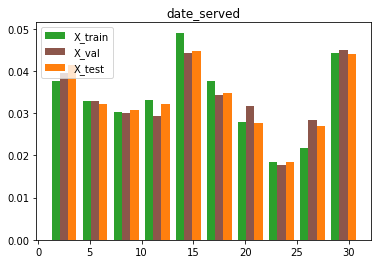

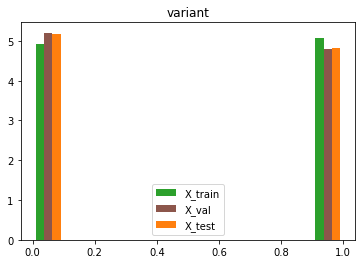

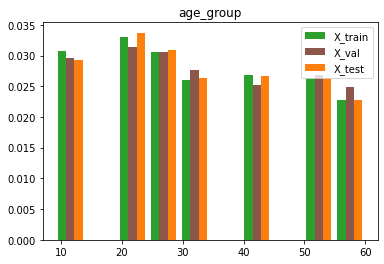

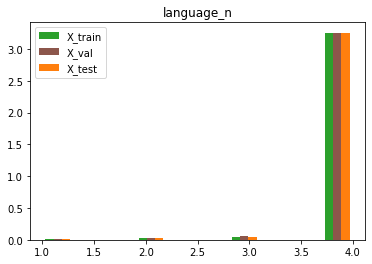

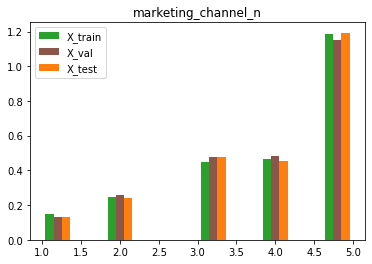

In [56]:
for col in cat_cal:
    plt.hist([X_train[col], X_val[col], X_test[col]], density=True,
         label=['X_train', 'X_val', 'X_test'], color=['tab:green', 'tab:brown', 'tab:orange'])
    plt.legend()
    plt.title(col)
    plt.show()

In [57]:
X_train['language_n'].value_counts(normalize=True)

4    0.976171
3    0.013238
2    0.007128
1    0.003462
Name: language_n, dtype: float64

In [58]:
X_val['language_n'].value_counts(normalize=True)

4    0.975297
3    0.016627
2    0.006651
1    0.001425
Name: language_n, dtype: float64

In [59]:
X_test['language_n'].value_counts(normalize=True)

4    0.975058
3    0.011972
2    0.010642
1    0.002328
Name: language_n, dtype: float64

In [60]:
# selected_col = cat_cal+['marketing_channel_Email', 'marketing_channel_Facebook',
#        'marketing_channel_House Ads', 'marketing_channel_Instagram',
#        'marketing_channel_Push']
selected_col = cat_cal

In [61]:
model2 = CatBoostClassifier(random_state=13, silent=True)

In [62]:
params={'iterations':[30, 40, 50],
        'learning_rate':[0.1, 0.5, 0.8, 1],
        'depth':[3, 7, 10]
        }
grid = GridSearchCV(model2,
                    param_grid=params,
                    cv=5,
                    refit=False)

search = grid.fit(X_train[selected_col], y_train)
search.best_params_

{'depth': 3, 'iterations': 40, 'learning_rate': 0.8}

In [63]:
# model2 = CatBoostClassifier(depth=3, iterations=50, learning_rate=0.8, random_state=13, silent=True)
model2 = CatBoostClassifier(depth=3, iterations=40, learning_rate=0.8, random_state=13, silent=True)
# model2 = CatBoostClassifier(depth=7, iterations=40, learning_rate=0.5, random_state=13, silent=True)
model2.fit(X_train[selected_col], y_train)

In [64]:
preds = model2.predict_proba(X_val[selected_col])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.182615, F-Score=0.427, Precision=0.373, Recall=0.500


Базовая конверсия

In [65]:
С0 = y_val.sum()/len(y_val)
С0

0.10736342042755344

In [66]:
X_test.shape

(3007, 14)

In [67]:
X_A, X_B, y_A, y_B = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

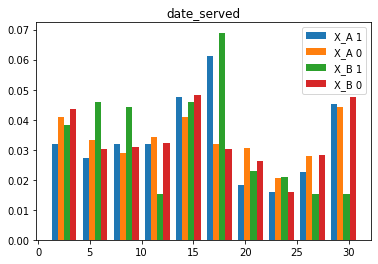

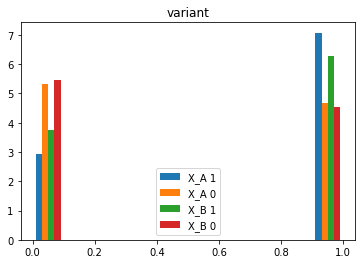

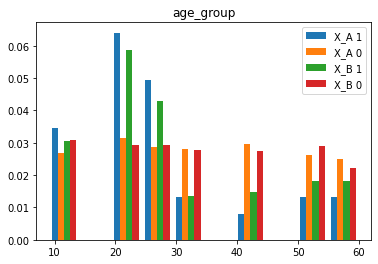

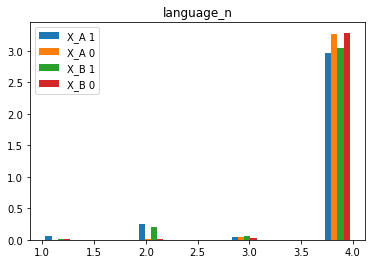

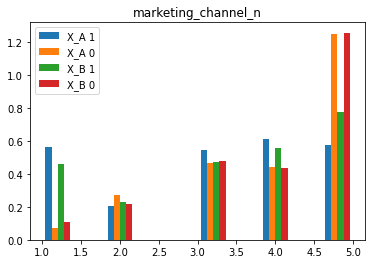

In [68]:
for col in cat_cal:
    plt.hist([X_A.loc[y_A==1, col], X_A.loc[y_A==0, col], X_B.loc[y_B==1, col], X_B.loc[y_B==0, col]], density=True,
         label=['X_A 1', 'X_A 0', 'X_B 1', 'X_B 0'])
    plt.legend()
    plt.title(col)
    plt.show()

Разбивка выглядит не идеальной, но вроде терпимой.

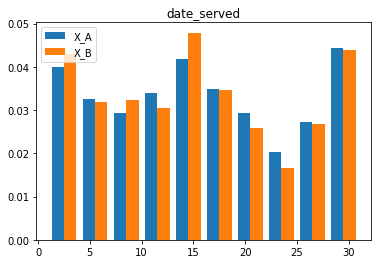

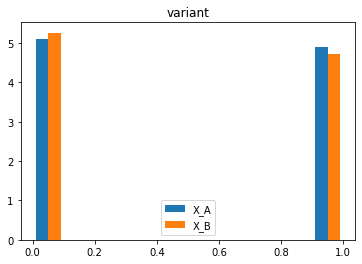

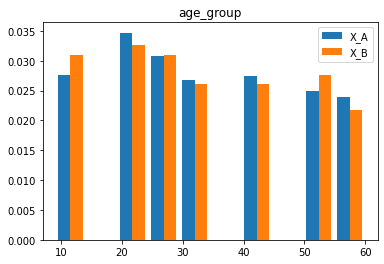

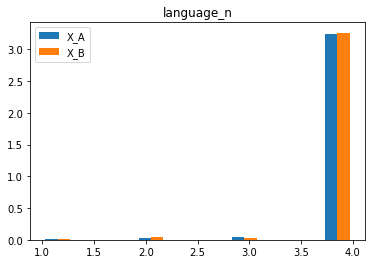

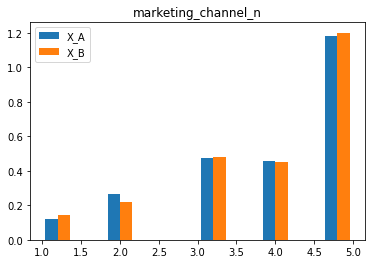

In [69]:
for col in cat_cal:
    plt.hist([X_A[col], X_B[col]], density=True,
         label=['X_A', 'X_B'])
    plt.legend()
    plt.title(col)
    plt.show()

In [70]:
C_A = y_A.sum()/len(y_A)
C_A

0.09780439121756487

In [71]:
predsB = model2.predict_proba(X_B[selected_col])[:, 1]
cnf_matrix = confusion_matrix(y_B, predsB > thresholds[ix])

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
print(cnf_matrix)

[[1192  138]
 [  88   86]]


In [72]:
k_ef = 0.1
# Мы выделили некоторую часть пользователей, которые не совершат покупку.
# Допустим, им что-то предложили и k_ef из них покупку теперь совершат
C_B = (TP + FN + TN*k_ef) / np.sum(cnf_matrix)
C_A, C_B

(0.09780439121756487, 0.19494680851063828)